# Results Classification

In [1]:
import os
import sys

sys.path.append('../')

import torch
import pandas as pd
import numpy as np

In [2]:
DATA_DIR = "../data"
data_train = pd.read_csv(os.path.join(DATA_DIR, "train_cleaned.csv"), na_filter=False)
data_val = pd.read_csv(os.path.join(DATA_DIR, "val_cleaned.csv"), na_filter=False)

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer
from datasets import load_metric

from utils.preprocessing import make_labels, tokenize

from utils.classes import SentimentDataset

In [4]:
MODEL = "xlm-roberta-base"
MODEL_PRETRAINED = "../models/xlm_roberta_classif/checkpoint-1758"
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PRETRAINED, num_labels=3)
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [5]:
X_train = tokenize(tokenizer, data_train.content)
X_val = tokenize(tokenizer, data_val.content)
y_train = data_train.sentiment
y_val = data_val.sentiment

In [6]:
y_train_labels = make_labels(y_train)
y_val_labels = make_labels(y_val)

In [7]:
data_train = data_train.assign(label=pd.Series(y_train_labels).values)
data_val = data_val.assign(label=pd.Series(y_val_labels).values)

In [8]:
train_dataset_torch = SentimentDataset(X_train, y_train_labels)
val_dataset_torch = SentimentDataset(X_val, y_val_labels)

In [9]:
metric = load_metric("accuracy")

In [10]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [11]:
training_args = TrainingArguments(
    "bert_base_uncased_classif",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=32,
    fp16 = True,
    fp16_opt_level = 'O1',
    evaluation_strategy = 'epoch',
    save_strategy="epoch",
    num_train_epochs=4
    
)

In [12]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_torch,
    eval_dataset=val_dataset_torch,
    compute_metrics=compute_metrics
)

Using amp fp16 backend


In [13]:
val_predictions = trainer.predict(val_dataset_torch)

***** Running Prediction *****
  Num examples = 6250
  Batch size = 8


In [14]:
val_predictions_labels = np.argmax(val_predictions.predictions, axis = 1)

In [15]:
metric.compute(predictions=val_predictions_labels, references=val_predictions.label_ids)

{'accuracy': 0.86416}

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

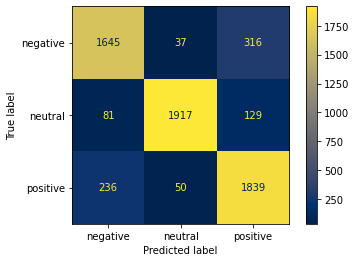

In [17]:
conf_matrix = confusion_matrix(val_predictions.label_ids, val_predictions_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels = ["negative", "neutral", "positive"],)
disp.plot( cmap="cividis")

In [18]:
data_val = data_val.assign(predictions=pd.Series(val_predictions_labels).values)

In [19]:
data_val

,Unnamed: 0,content,sentiment,language,label,predictions
0,19828,Marcelo Rebelo de Sousa e João Lourenço reunid...,neutral,pt,1,1
1,13131,Did you notice that zero has a karambit knife ...,positive,en,2,0
2,17486,"Page invita a Iceta a defenderle ""ante tanto i...",neutral,es,1,1
3,5955,Movimento de Mulheres cria aplicação para tele...,neutral,pt,1,1
4,8126,"GLOBAL MARKETS-US stocks rise, push Dow to rec...",neutral,en,1,1
...,...,...,...,...,...,...
6245,21682,@ 7anno他是我朋友之一的儿子,positive,zh-cn,2,2
6246,12555,Kohleausstieg lässt Hausmüllentsorgung möglich...,neutral,de,1,1
6247,16937,Y’a pas de confort.,negative,es,0,0
6248,6833,küsülülüyə əvvəlində biz zahirən bağlı obrazl...,negative,tr,0,0


In [20]:
results_by_language = []
for language in set(data_val.language):
    data = data_val[data_val.language == language]
    results_by_language.append((language,  metric.compute(predictions=data.predictions, references=data.label)["accuracy"], len(data)))
results_by_language = pd.DataFrame(results_by_language, columns=["language", "accuracy", "size"]).sort_values("size")[::-1]

In [21]:
results_by_language

,language,accuracy,size
9,en,0.837675,998
18,id,0.905000,800
49,ru,0.935687,793
17,ar,0.867965,462
19,fr,0.863747,411
22,es,0.898413,315
3,pt,0.899329,298
41,ko,0.836364,275
13,zh-cn,0.745455,220
28,ja,0.856354,181


## Results on the main languages

In [22]:
main_languages = ["en", "id", "ru", "ar", "fr", "es", "pt", "ko", "zh-cn", "ja", "de", "it", "th", "tr"]

In [23]:
 metric.compute(predictions=data_val[data_val.language.isin(main_languages)].predictions, references=data_val[data_val.language.isin(main_languages)].label)

{'accuracy': 0.8747130833970925}

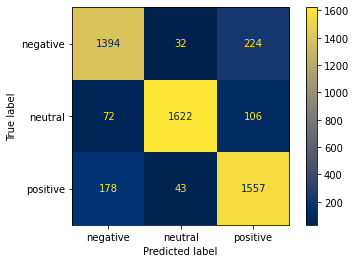

In [24]:
conf_matrix = confusion_matrix(data_val[data_val.language.isin(main_languages)].label, data_val[data_val.language.isin(main_languages)].predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels = ["negative", "neutral", "positive"],)
disp.plot( cmap="cividis")

## Anlayse results

Let's see what element have been misclassified

### Positive classified as negative

In [25]:
for sentence in data_val[data_val.language=="en"][data_val.label==2][data_val.predictions==0].content:
    print(sentence)

Did you notice that zero has a karambit knife and also that they changed the number 1 in the scoreboard and timer
 Smackgobbed?  New word for me...gonna start using all the time now.  
Anime Saturday about to start. New episode of bleach.  Yea 
So tired. Finally getting some sleep. Nighty 
If it was up to me I would give more berry's it is tottly not cool having to buy your eggs with berries I mean for real not cool update it a lift will you.
just came from the most romantic wedding ever. the groom almost cried, which made everyone else almost cry 
핸드폰 전체 세팅에서 말고 앱 내에서 개인이나 단톡방 알림끄기하면 소리는 안나는데 배너는 계속떠요. 아예 메세지가 안온거처럼 안뜨고 들어갈경우에만 받은 메세지가 보였으면 좋겠네요 Once i turn off the notification of a person/ group, as long as I don't check messages, i wish i do not see any notification(banner) and also number of accumulated messages on the list.
8 cm dilated and her water just broke. Getting closer 
Still thinking of Moscato, sigh... 
Tomorrow Demi in Madrid  I didn't win the concert to meet her LOL!
i

C:\Users\Louis\AppData\Local\Temp/ipykernel_15852/4078927634.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for sentence in data_val[data_val.language=="en"][data_val.label==2][data_val.predictions==0].content:


 From what we can see, these wrongly classified sentences are not obviously positive. Example : "hahas sucks to be you"

### Negative classified as positive

In [26]:
for sentence in data_val[data_val.language=="en"][data_val.label==0][data_val.predictions==2].content:
    print(sentence)

off to college  bleurgh
I know, I know, it's exactly like mine craft. But, IT KEEPS FREEZING!!!!!!!!!! You might think it is just nothing, but trust me, it freezes all the time. I hardly get the time to play it. I'd give it 0 stars if I could.
Rest in peace, Ping. Best hamster ever. 2007-2009 
It's a fucking holiday. I promise this will be my last day with this bank
     Mine are grown -- does reading to your dogs count?  :-D
off for a shower. i hope i drown... im so depressed right now  thanks a lot sharks
_ I think Iï¿½ll end up going alone  But I will see it at some point...
At Gatwick. Watch on BST, body 8 hours behind on PDT 
 Thanks. 7:30 here in CA but not on Versus. 
Can't believe she's up this early on a Sunday 
 omg you poooooor thing!!!!  don't worry you can use my itunes or something.....
 yeah got it, but was on my way with hubby to garage etc. 
it's beautiful out, and i have a 30 page outline to do 
Couldn't be happier with this application. Lots of good tools easy to use

C:\Users\Louis\AppData\Local\Temp/ipykernel_15852/4193792728.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for sentence in data_val[data_val.language=="en"][data_val.label==0][data_val.predictions==2].content:


Same conclusion here, some texts are not obviously negative.